In [1]:

import numpy
import mitsuba as mi 
import drjit as dr 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE3D.Coefficient import *
from PDE3D.utils import *
from PDE3D.BoundaryShape import *
from PDE3D.Solver import *
import argparse
from PDE3D.utils import *
import os

In [2]:

res_primal = [16, 16, 16]
name = "motorbike-engine"
epsilon = 1e-2
spp = 1024
param = "diffusion"
res_tex = 8

split = Split.Normal
fd_step = 0.01


In [3]:
def dirichlet(points, params):
    return dr.sin(points[0] * params["x"]) + dr.cos(points[1] * points[2] * params["yz"])
params1 = {}
params1["x"] = 0.2
params1["yz"] = 0.4

params2 = {}
params2["x"] = 4
params2["yz"] = 0.4

boundary_cond1 = FunctionCoefficient("dirichlet", params1, dirichlet)
boundary_cond2 = FunctionCoefficient("dirichlet", params2, dirichlet)
conf_numbers = [mi.UInt32(0), mi.UInt32(1)]

In [4]:
folder_name = os.path.join(PATH, "scenes", name)
xml_name = os.path.join(folder_name, "scene.xml")
sdf_data = np.load(os.path.join(folder_name, "sdf.npy"))

sdf = SDF(sdf_data, mesh_scene_xml=xml_name, dirichlet = [boundary_cond1, boundary_cond2], epsilon=epsilon)

bbox = sdf.mesh_scene.bbox()
bbox_pad = (bbox.max - bbox.min) / 10
bbox_coeff = mi.ScalarBoundingBox3f(bbox.min - bbox_pad, bbox.max + bbox_pad)

resolution_tex = [res_tex, res_tex, 1]
points_bbox = create_bbox_points(bbox_coeff, resolution_tex, spp = 1, centered = True)

def source(points : mi.Point3f):
    return dr.sin(6 * points[0] * points[1] + points[0]) + 1

def screening(points : mi.Point3f):
    return dr.sin(2 * points[0] * points[1] + points[1]) + 2

def diffusion(points : mi.Point3f):
    return (dr.sin(16 * points[0] * points[1]) + 3) * 10 - 10


source_vals = source(points_bbox) 
vol_source, _ = create_volume_from_result(source_vals, resolution_tex)

screening_vals = screening(points_bbox) 
vol_screening, _ = create_volume_from_result(screening_vals, resolution_tex)

diffusion_vals = diffusion(points_bbox)
vol_diffusion,_ = create_volume_from_result(diffusion_vals, resolution_tex)


In [5]:

f = TextureCoefficient("source", bbox_coeff, vol_source[0])
σ = TextureCoefficient("screening", bbox_coeff, vol_screening[0])
σ = ConstantCoefficient("screening", 0)
α = TextureCoefficient("diffusion", bbox_coeff, vol_diffusion[0])
data_holder = DataHolder(shape = sdf, α = α, σ = σ, f=f)
print(data_holder.σ_bar)
wos = WosVariable(data_holder, opt_params= [f"{param}.texture.tensor"])
opt = mi.ad.Adam(lr = 0.1, params = wos.opt_params)
wos.update(opt)

[2.49827]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].


Text(0.5, 1.0, 'Boundary Condition')

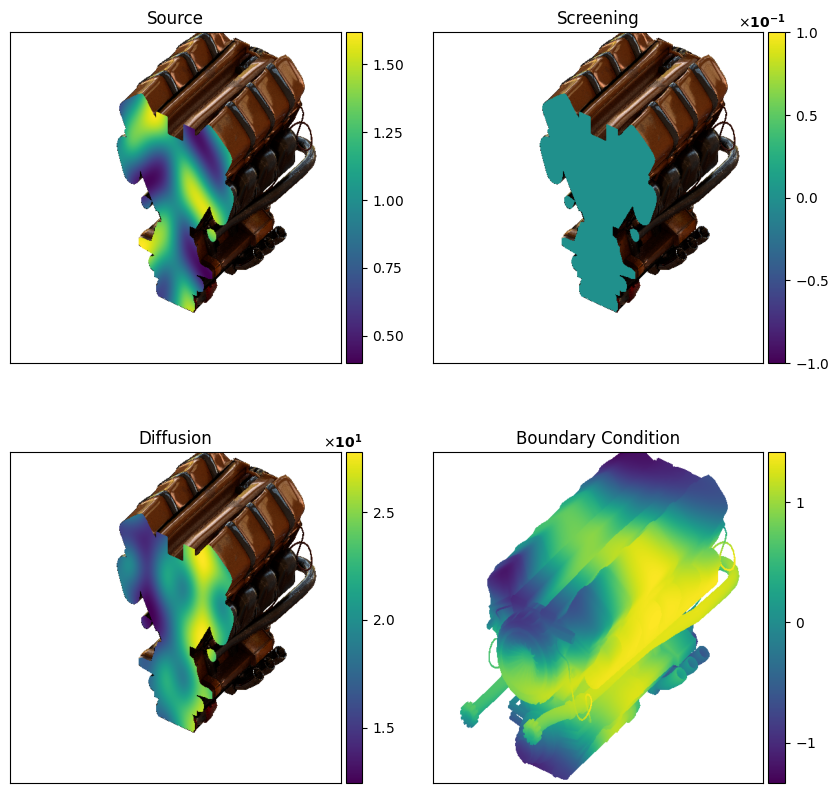

In [6]:
res_slice = [512, 512]
slice = Slice(offset =0, scale = 7, axis = "z")
slice_points, _ = slice.create_slice_points(resolution = res_slice, spp = 1, centered = True)
f_vals = f.get_value(slice_points)
σ_vals = σ.get_value(slice_points)
α_vals = α.get_value(slice_points)
cam_res = [512, 512]
res_slice = [512, 512]
spp = 64
downsample = 1
cam_origin = mi.ScalarPoint3f([7,7,10])
scale_cam = 1/5
cam_target = mi.ScalarPoint3f([0.0,0.0,0.0])
cam_up = mi.ScalarPoint3f([0,1,0])
cmap = "viridis"

f3D, f_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=f)
σ3D, σ_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=σ)
α3D, α_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff= α)

dirichlet3D, dirichlet_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up,cam_target = cam_target, conf_number=0)

fig, ax = plt.subplots(2,2, figsize = (10,10))

plot_image_3D(f3D, ax[0,0], norm = f_norm, cmap = cmap)
plot_image_3D(σ3D, ax[0,1], norm = σ_norm, cmap = cmap)
plot_image_3D(α3D, ax[1,0], norm = α_norm, cmap = cmap)
plot_image_3D(dirichlet3D, ax[1,1], norm = dirichlet_norm, cmap = cmap)

ax[0,0].set_title("Source")
ax[0,1].set_title("Screening")
ax[1,0].set_title("Diffusion")
ax[1,1].set_title("Boundary Condition")

In [7]:
points = create_bbox_points(bbox, res_primal, spp, centered = True)

L, p = wos.solve(points_in = points, conf_numbers = conf_numbers, split = split)
image_0, tensor = create_volume_from_result(L, res_primal)

loss_grad = compute_loss_grad_vol(result = tensor)
dL = compute_dL_vol(loss_grad=loss_grad, spp = spp)

0 : 262144 -> 599
1 : 599 -> 14
2 : 14 -> 0


In [8]:
L_grad, p = wos.solve_grad(points_in = points, split = split, dL = dL, conf_numbers=conf_numbers, verbose = True)
if param == "source":
    grad_prb = dr.grad(f.tensor).numpy()
elif param == "screening":
    grad_prb = dr.grad(σ.tensor).numpy()
elif param == "diffusion":
    grad_prb = dr.grad(α.tensor).numpy()

0 : 262144 -> 599
1 : 599 -> 14
2 : 14 -> 0


In [9]:
def step_texture(texture : Coefficient, i, j, k, fd_step):
    tex1 = texture.copy()
    tex2 = texture.copy()
    index = i * tex1.tensor.shape[2] * tex1.tensor.shape[1] + j * tex1.tensor.shape[2] + k
    dr.scatter_add(tex1.tensor.array, +fd_step, index)
    dr.scatter_add(tex2.tensor.array, -fd_step, index)
    dr.make_opaque(tex1.tensor)
    dr.make_opaque(tex2.tensor)
    tex1.update_texture()
    tex2.update_texture()
    return tex1, tex2

def get_data_holder(i, j, k):
    if param == "source":
        f1, f2 = step_texture(f, i, j, k, fd_step)
        data_holder1 = DataHolder(shape = sdf, α = α, α_split = α, f = f1, σ_split = σ, σ = σ)
        data_holder2 = DataHolder(shape = sdf, α = α, α_split = α, f = f2, σ_split = σ, σ = σ)
    elif param == "screening":
        σ1, σ2 = step_texture(σ, i, j, k, fd_step)
        data_holder1 = DataHolder(shape = sdf, α = α, α_split = α, f = f, σ_split = σ, σ = σ1)
        data_holder2 = DataHolder(shape = sdf, α = α, α_split = α, f = f, σ_split = σ, σ = σ2)
    elif param == "diffusion":
        α1, α2 = step_texture(α, i, j, k, fd_step)
        data_holder1 = DataHolder(shape = sdf, α = α1, α_split = α, f = f, σ_split = σ, σ = σ)
        data_holder2 = DataHolder(shape = sdf, α = α2, α_split = α, f = f, σ_split = σ, σ = σ)
    return data_holder1, data_holder2

In [10]:
grad_fd = np.zeros(resolution_tex)
for i in range(resolution_tex[0]):
    for j in range(resolution_tex[1]):
        for k in range(resolution_tex[2]):
            data_holder1, data_holder2 = get_data_holder(i,j,k)
            wos1 = WosVariable(data_holder1)
            wos2 = WosVariable(data_holder2)
            points = create_bbox_points(bbox, res_primal, spp, centered = True)
            L1, _ = wos1.solve(points, split = split, conf_numbers=conf_numbers, fd_forward=True, verbose = False)
            L2, _ = wos2.solve(points, split = split, conf_numbers=conf_numbers, fd_forward=True, verbose = False)
            image1, tensor1 = create_volume_from_result(L1, res_primal)
            image2, tensor2 = create_volume_from_result(L2, res_primal)
            val1 = np.sum(MSE_numpy(image1))
            val2 = np.sum(MSE_numpy(image2))
            print(val1, val2)
            grad_fd[i,j,k] = (val1 - val2) / (2 * fd_step)
            print(f"{i},{j},{k}")

0.48756582 0.48756582
0,0,0
0.48756582 0.48756582
0,1,0
0.48756582 0.48756582
0,2,0
0.48756582 0.48756582
0,3,0
0.48756564 0.487566
0,4,0
0.4875655 0.48756617
0,5,0
0.48756567 0.48756596
0,6,0
0.48756582 0.48756582
0,7,0
0.48756582 0.48756582
1,0,0
0.48756588 0.48756576
1,1,0
0.487566 0.48756567
1,2,0
0.48756623 0.48756537
1,3,0
0.48756748 0.48756412
1,4,0
0.48756507 0.48756656
1,5,0
0.48756492 0.4875667
1,6,0
0.48756593 0.4875657
1,7,0
0.4875658 0.48756588
2,0,0
0.4875657 0.48756593
2,1,0
0.48756605 0.48756558
2,2,0
0.48756713 0.48756453
2,3,0
0.48757172 0.48755997
2,4,0
0.4875649 0.48756674
2,5,0
0.48756427 0.48756737
2,6,0
0.48756614 0.48756546
2,7,0
0.48756564 0.48756596
3,0,0
0.48756498 0.48756665
3,1,0
0.48756462 0.487567
3,2,0
0.4875648 0.4875668
3,3,0
0.48756707 0.48756456
3,4,0
0.48756304 0.4875686
3,5,0
0.48756385 0.48756775
3,6,0
0.48756585 0.48756582
3,7,0
0.48756585 0.4875658
4,0,0
0.4875654 0.48756623
4,1,0
0.4875652 0.48756644
4,2,0
0.487567 0.48756462
4,3,0
0.48756576 0

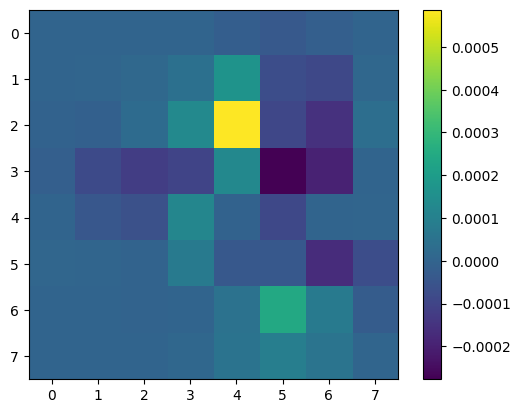

In [11]:
plt.imshow(grad_fd)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].


Text(0.5, 1.0, 'Difference')

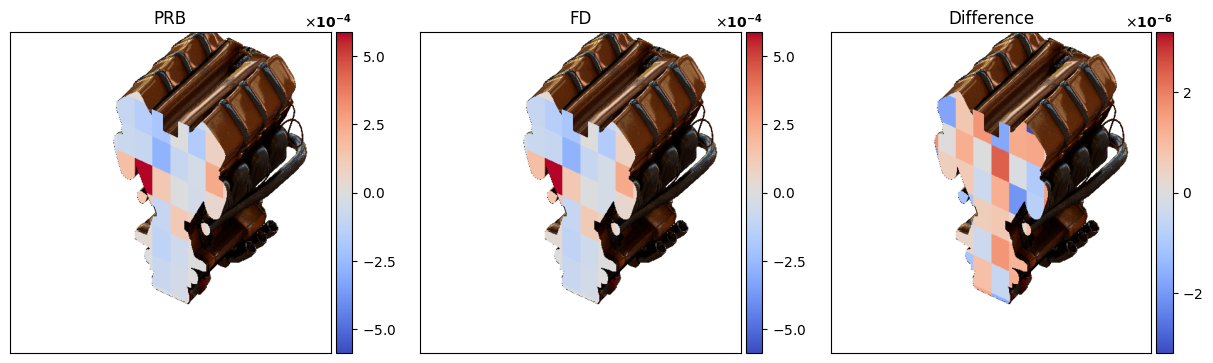

In [12]:
prb_tex = TextureCoefficient("prb", bbox_coeff, np.squeeze(grad_prb)[:,:,np.newaxis], interpolation = "nearest")
fd_tex = TextureCoefficient("prb", bbox_coeff, np.squeeze(grad_fd)[:,:,np.newaxis], interpolation = "nearest")
diff_tex = TextureCoefficient("prb", bbox_coeff, (np.squeeze(grad_prb) - np.squeeze(grad_fd))[:, :, np.newaxis], interpolation = "nearest")
cmap = "coolwarm"
prb3D, prb_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff= prb_tex, sym_colorbar=True)
fd3D, fd_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff= fd_tex, sym_colorbar=True)
diff3D, diff_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff= diff_tex, sym_colorbar=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (15,5))
plot_image_3D(prb3D, ax1, norm = prb_norm, cmap = cmap)
plot_image_3D(fd3D, ax2, norm = fd_norm, cmap = cmap)
plot_image_3D(diff3D, ax3, norm = diff_norm, cmap = cmap)
ax1.set_title("PRB")
ax2.set_title("FD")
ax3.set_title("Difference")

In [13]:
fig.savefig("fd.jpg", pad_inches = 0, dpi = 300)